<a href="https://colab.research.google.com/github/asu-trans-ai-lab/Integrated_modeling_GMNS/blob/main/MRM_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction
- **GMNS**: The General Modeling Network Specification (GMNS) defines a common human and machine-readable format for sharing routable road network files. It is designed to be used in multi-modal static and dynamic transportation planning and operations models.

- **AMS**: The objective of the AMS data hub is to define a prototype of operations and associated requirements that will allow for the effective integration of analysis modeling and simulation tools across various domains and scales. Easily exchange information and data at both the input and output levels.

- **ASU Trans + AI Lab**: The team devotes to developing a better AMS data hub framework and a set of integrated open-source transportation tools. The objective of this notebook is to aggregate the developed software as a systematic modeling flow and demonstrate its successive steps, so call “7-steps modeling”. 


In [ ]:
!pip install osm2gmns
!pip install net2cell
!pip install grid2demand

     |████████████████████████████████| 51kB 2.3MB/s 
     |████████████████████████████████| 1.0MB 7.5MB/s 
  Found existing installation: protobuf 3.12.4
    Uninstalling protobuf-3.12.4:
      Successfully uninstalled protobuf-3.12.4


In [ ]:
"import packages"
import pandas as pd
import osm2gmns as og 
import net2cell as nc
import grid2demand as gd

from google.colab import files
import requests
import io
import os
import time

osm2gmns, version 0.4.2
ocean, version 0.1.1
grid2demand, version 0.0.1.25


#### Step 0. OSM data download

https://osm2gmns.readthedocs.io/en/latest/index.html
----
| Step |    Description    |       Software       | Input Files | Output Files |
|:----:|:-----------------:|:--------------------:|:-----------:|:------------:|
| 0    | OSM data download | Open Street Map(OSM) | - -         | Map.osm      |

In [ ]:
"Step 0.1 define output map folders"
map_folder = 'map_folder'
hybrid_net_folder = 'MRM_net_folder'

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving map.osm to map.osm
User uploaded file "map.osm" with length 62061895 bytes


#### Step 1. Convert OSM data to GMNS
one can display the network in NeXTA or QGIS.

---
| Step |    Description    |       Software       | Input Files | Output Files |
|:----:|:-----------------:|:--------------------:|:-----------:|:------------:|
| 0    | OSM data download | Open Street Map(OSM) | - -         | Map.osm      |

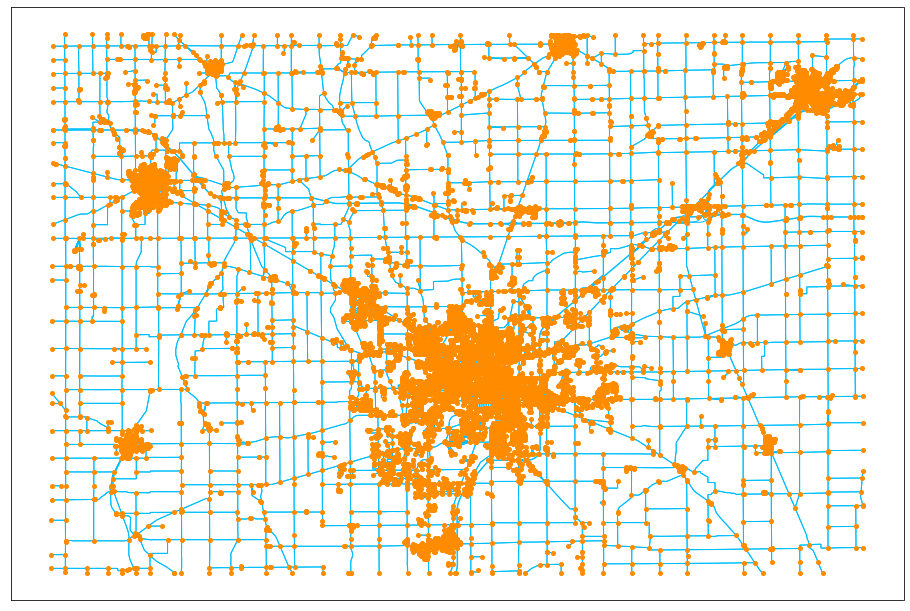

Figure is saved to network.jpg


In [ ]:
"Step 1.1 get openstreet map file"
net = og.getNetFromOSMFile('map.osm', POIs=True,default_speed=True, default_lanes=True)

"Step 1.2 join poi information and activity information"
og.connectPOIWithNet(net)
og.generateNodeActivityInfo(net)

map_folder = 'map_folder'
hybrid_net_folder = 'MRM_net_folder'

"Step 1.3 convert openstreet map file into GMNS network files: node.csv and link.csv"
og.outputNetToCSV(net, output_folder=map_folder)
og.show(net)
og.saveFig(net) 


#### Step 2. Please check content folder on the left side.  Convert GTFS data to GMNS

#### Step 3. Expand macroscopic network data to micro, meso
one can display the networks in NeXTA or QGIS.

---
| Step |                   Description                  | Software |     Input Files    |                   Output Files                   |
|:----:|:----------------------------------------------:|:--------:|:------------------:|:------------------------------------------------:|
| 3    | Expand macroscopic network data to micro, meso | net2cell | Node.csv, Link.csv | Meso and micro networks in node.csv and link.csv |

In [ ]:
"Step 3.1 consolidate nodes in intersections"
og.consolidateComplexIntersections(net)
og.outputNetToCSV(net, output_folder=hybrid_net_folder)
"Step 3.2 read macro network and convert it into hybrid networks (i.e. meso and micro net)"
macro_net = nc.readMacroNet(cwd=hybrid_net_folder)
nc.generateHybridNets(macro_net)

Reading input data...
  reading node.csv
  reading link.csv
  removing links shorter than 3.0 meters
  46 short links have been removed
Initilizing original links...
Generating normal meso links...
Generating connector links...
Converting coordiantes back to latlon
Output networks...



Step 4. Zone-to-zone travel demand

---
| Step |         Description        |   Software  |                   Input Files                  |                       Output Files                       |
|:----:|:--------------------------:|:-----------:|:----------------------------------------------:|:--------------------------------------------------------:|
| 4    | Zone-to-zone travel demand | grid2demand | Node.csv, Link.csv, Poi.csv, Poi_trip_rate.csv | Demand.csv, Zone.csv, Accessibility.csv, Input_agent.csv |

In [ ]:
"Step 4.1: Read Input Network Data"
net = gd.ReadNetworkFiles(input_folder=map_folder)

"Step 4.2: Partition Grid into cells"
zone = gd.PartitionGrid(number_of_x_blocks=5, number_of_y_blocks=5, cell_width=None, cell_height=None,
                           latitude=30)
# user can customize number of grid cells or cell's width and height

"Step 4.3: Get Production/Attraction Rates of Each Land Use Type with a Specific Trip Purpose"
triprate = gd.GetPoiTripRate(trip_rate_folder='',trip_purpose=1)
# user can customize poi_trip_rate.csv and trip purpose

"Step 4.4: Define Production/Attraction Value of Each Node According to POI Type"
nodedemand = gd.GetNodeDemand()

"Step 4.5: Calculate Zone-to-zone Accessibility Matrix by Centroid-to-centroid Straight Distance"
accessibility = gd.ProduceAccessMatrix(latitude=30, accessibility_folder='')
# user can customize the latitude of the research area and accessibility.csv

"Step 4.6: Apply Gravity Model to Conduct Trip Distribution"
demand = gd.RunGravityModel(trip_purpose=1, a=None, b=None, c=None)
# user can customize friction factor coefficients under a specific trip purpose
"Step 7: Generate Agent"
demand = gd.GenerateAgentBasedDemand()

2021-04-01 22:30:03,782 - grid2demand_0330a.py[line:848] - WARNING: poi_trip_rate.csv does not exist in the current folder. Default values will be used.
2021-04-01 22:30:03,812 - grid2demand_0330a.py[line:971] - WARNING: Production value of residential nodes is not defined! Default value is 10.
2021-04-01 22:30:03,814 - grid2demand_0330a.py[line:974] - WARNING: Attraction value of residential nodes is not defined! Default value is 10.
2021-04-01 22:30:03,816 - grid2demand_0330a.py[line:977] - WARNING: Production value of boundary nodes is not defined! Default value is 1000.
2021-04-01 22:30:03,818 - grid2demand_0330a.py[line:980] - WARNING: Attraction value of boundary nodes is not defined! Default value is 1000.



Number of zones including virtual zones = 45

Tab of trip purposes used in grid2demand =  1

Total number of poi nodes with unmatched production rate =  1566
Total number of poi nodes with unmatched attraction rate =  598

Latitude used for grid2demand =  30

Number of OD pairs =  2025

Largest accessibility of distance = 67.18 km
Average accessibility of distance = 27.86 km

Default values of friction factor coefficients under trip purpose 1: 
a= 28507 
b= -0.02 
c= -0.123

Zone-to-zone OD pair with largest volume is from Gate18 to Gate17
Origin zone with largest production volume is Gate18
Destination zone with largest attraction volume is Gate18

Number of agents =  1196519


#### Step 5. Traffic signal for timing

---
| Step |        Description        |                 Software                |            Input Files           | Output Files |
|:----:|:-------------------------:|:---------------------------------------:|:--------------------------------:|:------------:|
| 5    | Traffic signal for timing | Signal2timing (In development), Sigma-X | Node.csv, Link.csv, Movement.csv | Timing.csv   |

In [ ]:

!zip -r /content/MRM.zip /content


updating: content/map_folder/ (stored 0%)
updating: content/map_folder/accessibility.csv (deflated 81%)
updating: content/map_folder/input_agent.csv (deflated 80%)
updating: content/map_folder/poi_trip_rate.csv (deflated 77%)
updating: content/map_folder/poi.csv (deflated 74%)
updating: content/map_folder/log.txt (deflated 92%)
updating: content/map_folder/demand.csv (deflated 74%)
updating: content/map_folder/link.csv (deflated 81%)
updating: content/map_folder/node.csv (deflated 76%)
updating: content/map_folder/zone.csv (deflated 76%)
  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2021.03.25/ (stored 0%)
  adding: content/.config/logs/2021.03.25/13.38.09.835215.log (deflated 54%)
  adding: content/.config/logs/2021.03.25/13.37.29.839683.log (deflated 91%)
  adding: content/.config/logs/2021.03.